# Imported Libraries

In [37]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib.patches as mpatches
import time

# Classifier Libraries
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
import collections


# Other Libraries
from imblearn.datasets import fetch_datasets
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as imbalanced_make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from imblearn.metrics import classification_report_imbalanced
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report
from collections import Counter
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings("ignore")

# streamlit import 
import streamlit as st
import sys
directory_path = 'D:/'
sys.path.append(directory_path)

In [38]:
#val - number of days
def antecedent_rainfall(dr,val):
    for i in range(1,val+1):
        s = "antecedent_"+ str(i) + "days"
        x = i + 1
        dr[s] = np.around(abs(dr.depth.rolling(x).sum() - dr.depth),decimals=7)
        
    return dr
#15days antecedent rainfall
#antecedent_rainfall(dr,180)

# Preprocessing rainfall data (dr)

In [39]:
def preprocessing_of_rainfall_data(data, frequency_of_data):
    data = data.replace(-9999.9, np.nan)
    data.columns = ['time','intensity']
    
    data = data.fillna(0)
    data['depth'] = data['intensity'] * frequency_of_data
    data['time'] = pd.to_datetime(data['time'])
    data = data.set_index('time', drop=True)
   # del data.index.name
    
    data = data.drop(['intensity'],axis=1)
    
    return data

In [40]:
def preprocessing_of_rainfall_data(data, frequency_of_data):
    data = data.replace(-9999.9, np.nan)
    data.columns = ['time','intensity']
    
    data = data.fillna(0)
    data['depth'] = data['intensity'] * frequency_of_data
    data['time'] = pd.to_datetime(data['time'])
    data = data.set_index('time', drop=True)
    #del data.index.name
    
    data = data.drop(['intensity'],axis=1)
    
    return data

# Preprocessing landslide data (dl)


In [41]:
def preprocessing_of_landslide_data(data):
    data.columns = ['time','landslide']
    data['time'] = pd.to_datetime(data['time'])
    data = data.set_index('time', drop=True)
    #del data.index.name
    
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    
    landslide_years = data.index.year.unique()
    
    return data, landslide_years



# Merging both data  (df)


In [42]:
def merging_both_data(rainfall_data, landslide_data): 
    data = rainfall_data.join(landslide_data)
    
    data = data.fillna(0)
    data = data.drop(columns=['year','month','day'])
    
    
    return data


In [43]:
dr = preprocessing_of_rainfall_data(pd.read_csv('E:/78.9811,30.2587,79.5660,30.5506/RainfallData/TRMM/2003-2019/DailyTRMM.csv'), 24)
dl, landslide_years = preprocessing_of_landslide_data(pd.read_csv('E:/78.9811,30.2587,79.5660,30.5506/LandslideData/Landslide - Sheet2.csv'))

In [44]:
df = merging_both_data(dr,dl)

In [45]:
df = antecedent_rainfall(df,30)

In [46]:
df = df.dropna(axis=0)

# The classes are heavily skewed we need to solve this issue later.


In [47]:
print('No Frauds', round(df['landslide'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Frauds', round(df['landslide'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

No Frauds 98.85 % of the dataset
Frauds 1.15 % of the dataset


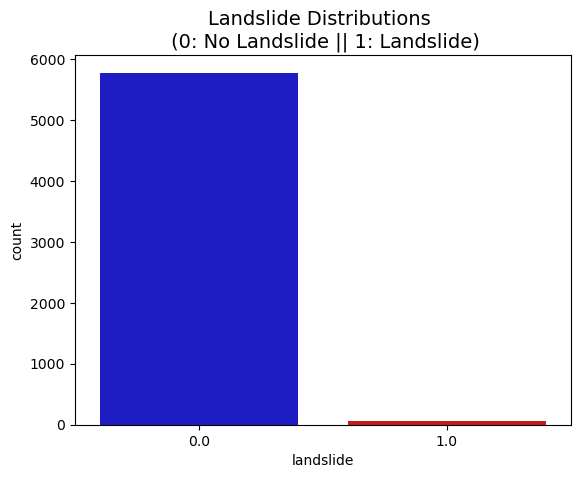

DeltaGenerator()

In [48]:
colors = ["#0101DF", "#DF0101"]

sns.countplot('landslide', data=df, palette=colors)
plt.title('Landslide Distributions \n (0: No Landslide || 1: Landslide)', fontsize=14)
plt.show()

st.subheader('Landslide Distributions \n (0: No Landslide || 1: Landslide)')
st.pyplot()

In [57]:
from sklearn.preprocessing import StandardScaler, RobustScaler

# RobustScaler is less prone to outliers.

std_scaler = StandardScaler()
rob_scaler = RobustScaler()


for i in df.columns:
    if i != 'landslide':
        df[i] = rob_scaler.fit_transform(df[i].values.reshape(-1,1))

#Since most of our data has already been scaled we should scale the columns that are left to scale (Amount and Time)

In [58]:
df

,depth,landslide,antecedent_1days,antecedent_2days,antecedent_3days,antecedent_4days,antecedent_5days,antecedent_6days,antecedent_7days,antecedent_8days,...,antecedent_21days,antecedent_22days,antecedent_23days,antecedent_24days,antecedent_25days,antecedent_26days,antecedent_27days,antecedent_28days,antecedent_29days,antecedent_30days
time,,,,,,,,,,,,,,,,,,,,,
2003-03-31,0.00000,0.0,0.02500,0.021277,-0.006656,-0.040975,-0.072169,0.229620,0.235712,0.159465,...,-0.176499,-0.185872,-0.194659,-0.202569,-0.208069,-0.227730,-0.234397,-0.240211,-0.255957,-0.262189
2003-04-01,0.00000,0.0,0.00000,0.006079,-0.006656,-0.040975,-0.072169,-0.099864,0.148706,0.153259,...,-0.176499,-0.185872,-0.194659,-0.202569,-0.208069,-0.227730,-0.234397,-0.240211,-0.255957,-0.262189
2003-04-02,0.00000,0.0,0.00000,0.000000,-0.014975,-0.040975,-0.072169,-0.099864,-0.127097,0.080210,...,-0.176499,-0.185872,-0.194659,-0.202569,-0.208069,-0.227730,-0.234397,-0.240211,-0.255957,-0.262189
2003-04-03,0.00000,0.0,0.00000,0.000000,-0.018303,-0.046512,-0.072169,-0.099864,-0.127097,-0.151349,...,-0.176499,-0.185872,-0.194659,-0.202569,-0.208069,-0.227730,-0.234397,-0.240211,-0.255957,-0.262189
2003-04-04,0.10000,0.0,0.00000,0.000000,-0.018303,-0.048726,-0.076317,-0.099864,-0.127097,-0.151349,...,-0.176499,-0.185872,-0.194659,-0.202569,-0.208069,-0.227730,-0.234397,-0.240211,-0.255957,-0.262189
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-03-23,0.00000,0.0,0.00000,0.000000,-0.018303,-0.048726,-0.077976,-0.095788,-0.123685,-0.148484,...,-0.216792,-0.224070,-0.231017,-0.237215,-0.205020,-0.224779,-0.231550,-0.237474,-0.253232,-0.251083
2019-03-24,0.00000,0.0,0.00000,0.000000,-0.018303,-0.048726,-0.077976,-0.104620,-0.123685,-0.148484,...,-0.228359,-0.224070,-0.231017,-0.237215,-0.240754,-0.224779,-0.231550,-0.237474,-0.253232,-0.259548
2019-03-25,9.88125,0.0,0.00000,0.000000,-0.018303,-0.048726,-0.077976,-0.104620,-0.131078,-0.148484,...,-0.228359,-0.235036,-0.231017,-0.237215,-0.240754,-0.259366,-0.231550,-0.237474,-0.253232,-0.259548


# StratifiedShuffleSplit 
is a cross-validation technique used in machine learning to split a dataset into training and test sets while ensuring that the class distribution of the target variable (or any categorical variable of interest) is preserved in both the training and test sets. It is particularly useful when dealing with imbalanced datasets, where some classes have significantly fewer examples than others.


We already have X_train and y_train for undersample data thats why I am using original to distinguish and to not overwrite these variables.
original_Xtrain, original_Xtest, original_ytrain, original_ytest = train_test_split(X, y, test_size=0.2, random_state=42)

In [59]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit

print('No Landslide', round(df['landslide'].value_counts()[0]/len(df) * 100,2), '% of the dataset')
print('Landslide', round(df['landslide'].value_counts()[1]/len(df) * 100,2), '% of the dataset')

X = df.drop('landslide', axis=1)
y = df['landslide']

sss = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

for train_index, test_index in sss.split(X, y):
    print("Train:", train_index, "Test:", test_index)
    original_Xtrain, original_Xtest = X.iloc[train_index], X.iloc[test_index]
    original_ytrain, original_ytest = y.iloc[train_index], y.iloc[test_index]

# Check the Distribution of the labels


# Turn into an array
original_Xtrain = original_Xtrain.values
original_Xtest = original_Xtest.values
original_ytrain = original_ytrain.values
original_ytest = original_ytest.values

# See if both the train and test label distribution are similarly distributed
train_unique_label, train_counts_label = np.unique(original_ytrain, return_counts=True)
test_unique_label, test_counts_label = np.unique(original_ytest, return_counts=True)
print('-' * 100)

print('Label Distributions: \n')
print(train_counts_label/ len(original_ytrain))
print(test_counts_label/ len(original_ytest))

No Landslide 98.85 % of the dataset
Landslide 1.15 % of the dataset
Train: [4106 2055 2593 ... 3119 3695 5074] Test: [1809  470 2495 ...  814 1962 1139]
Train: [2795 2449 5347 ... 4830 3033 5727] Test: [2528 5458 2381 ...  488  968 2065]
Train: [ 334 2632 3907 ... 2478 1989 3928] Test: [3464 1875 2435 ... 1280 5221  432]
Train: [1352 1476 2457 ... 3163 1928 5803] Test: [2888 2788 2206 ... 3330 2058 5745]
Train: [5186  147 4749 ... 1169 1072 2190] Test: [ 279 4830 4951 ...  433  102 1676]
----------------------------------------------------------------------------------------------------
Label Distributions: 

[0.98844178 0.01155822]
[0.98887938 0.01112062]


In [60]:
df.describe()


,depth,landslide,antecedent_1days,antecedent_2days,antecedent_3days,antecedent_4days,antecedent_5days,antecedent_6days,antecedent_7days,antecedent_8days,...,antecedent_21days,antecedent_22days,antecedent_23days,antecedent_24days,antecedent_25days,antecedent_26days,antecedent_27days,antecedent_28days,antecedent_29days,antecedent_30days
count,5841.000000,5841.000000,5841.000000,5841.000000,5841.000000,5841.000000,5841.000000,5841.000000,5841.000000,5841.000000,...,5841.000000,5841.000000,5841.000000,5841.000000,5841.000000,5841.000000,5841.000000,5841.000000,5841.000000,5841.000000
mean,2.267678,0.011471,2.267682,1.102827,0.887038,0.754585,0.674135,0.634534,0.590800,0.537987,...,0.430867,0.423053,0.416466,0.409844,0.398031,0.386365,0.384384,0.380091,0.387040,0.385461
std,6.319794,0.106494,6.319793,2.515516,1.847539,1.516611,1.339474,1.256701,1.184168,1.104429,...,0.983112,0.968853,0.956996,0.944745,0.922014,0.922087,0.917778,0.909304,0.932223,0.929117
min,0.000000,0.000000,0.000000,0.000000,-0.018303,-0.048726,-0.077976,-0.104620,-0.131078,-0.154691,...,-0.303355,-0.306132,-0.309124,-0.311645,-0.310970,-0.327329,-0.330462,-0.332561,-0.347914,-0.351300
25%,0.000000,0.000000,0.000000,0.000000,-0.018303,-0.048726,-0.077976,-0.104620,-0.131078,-0.154691,...,-0.255061,-0.255049,-0.254240,-0.251140,-0.247400,-0.261031,-0.258048,-0.260140,-0.267626,-0.270043
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.000000,1.000000,1.000000,0.981697,0.951274,0.922024,0.895380,0.868922,0.845309,...,0.744939,0.744951,0.745760,0.748860,0.752600,0.738969,0.741952,0.739860,0.732374,0.729957
max,105.393742,1.000000,105.393742,29.563831,22.330282,15.767442,14.522605,12.430368,10.870628,10.033660,...,7.444188,7.288952,7.100809,7.183755,6.981547,7.230682,7.344186,7.244070,7.228496,7.085726


In [61]:
st.dataframe(df.describe())


DeltaGenerator()

# Since our classes are highly skewed we should make them equivalent in order to have a normal distribution of the classes.

# Lets shuffle the data before creating the subsamples

In [62]:


df = df.sample(frac=1)

# amount of fraud classes 492 rows.
landslide_df = df.loc[df['landslide'] == 1]
non_landslide_df = df.loc[df['landslide'] == 0][:67]

normal_distributed_df = pd.concat([landslide_df, non_landslide_df])

# Shuffle dataframe rows
new_df = normal_distributed_df.sample(frac=1, random_state=42)

new_df.head()

,depth,landslide,antecedent_1days,antecedent_2days,antecedent_3days,antecedent_4days,antecedent_5days,antecedent_6days,antecedent_7days,antecedent_8days,...,antecedent_21days,antecedent_22days,antecedent_23days,antecedent_24days,antecedent_25days,antecedent_26days,antecedent_27days,antecedent_28days,antecedent_29days,antecedent_30days
time,,,,,,,,,,,,,,,,,,,,,
2013-04-17,0.000000,0.0,0.306250,0.319149,0.156406,0.105759,0.037744,-0.009851,-0.051749,-0.066842,...,-0.267881,-0.272503,-0.277116,-0.195856,-0.201736,-0.221600,-0.194540,-0.201544,-0.217455,-0.224878
2013-07-24,7.624999,1.0,1.800000,3.782675,5.095673,3.506644,5.372045,4.358696,3.723059,3.154213,...,1.797378,1.720917,1.624772,1.545959,1.476425,1.402710,1.401927,1.372982,1.377542,1.628115
2008-07-23,0.918750,0.0,0.987500,0.601824,0.697171,0.831672,1.166736,1.319294,1.843332,1.519217,...,1.959900,1.868226,1.785335,1.749358,1.682931,1.804284,1.942112,1.865754,1.842848,1.787378
2011-08-08,2.806250,1.0,21.731249,9.367781,6.660565,4.421927,4.038573,3.819294,3.262155,3.064455,...,2.375844,2.320113,2.260416,2.255450,2.243100,2.309241,2.459158,2.367439,2.423031,2.408654
2011-07-11,1.625000,1.0,7.374999,3.471125,1.911814,1.322259,1.949399,1.962296,1.938015,1.582478,...,1.288895,1.244814,1.167087,1.103688,1.024240,0.965035,0.916052,0.865754,0.847670,0.807286


Distribution of the Classes in the subsample dataset
0.0    0.5
1.0    0.5
Name: landslide, dtype: float64


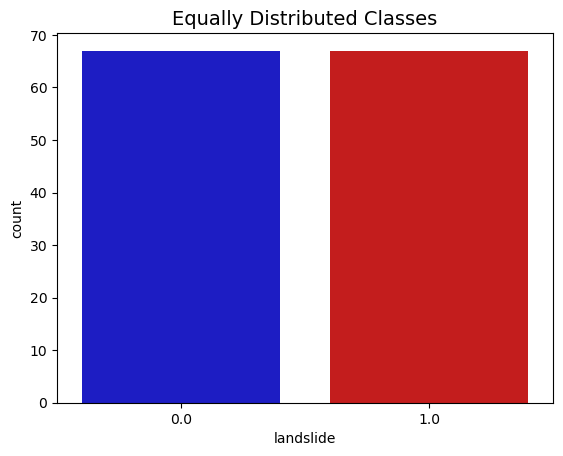

In [65]:
print('Distribution of the Classes in the subsample dataset')
print(new_df['landslide'].value_counts()/len(new_df))

sns.countplot('landslide', data=new_df, palette=colors)
plt.title('Equally Distributed Classes', fontsize=14)
plt.show()


In [66]:
st.subheader('Equally Distributed Classes')
st.pyplot()

DeltaGenerator()

# Make sure we use the subsample in our correlation


<Figure size 640x480 with 0 Axes>

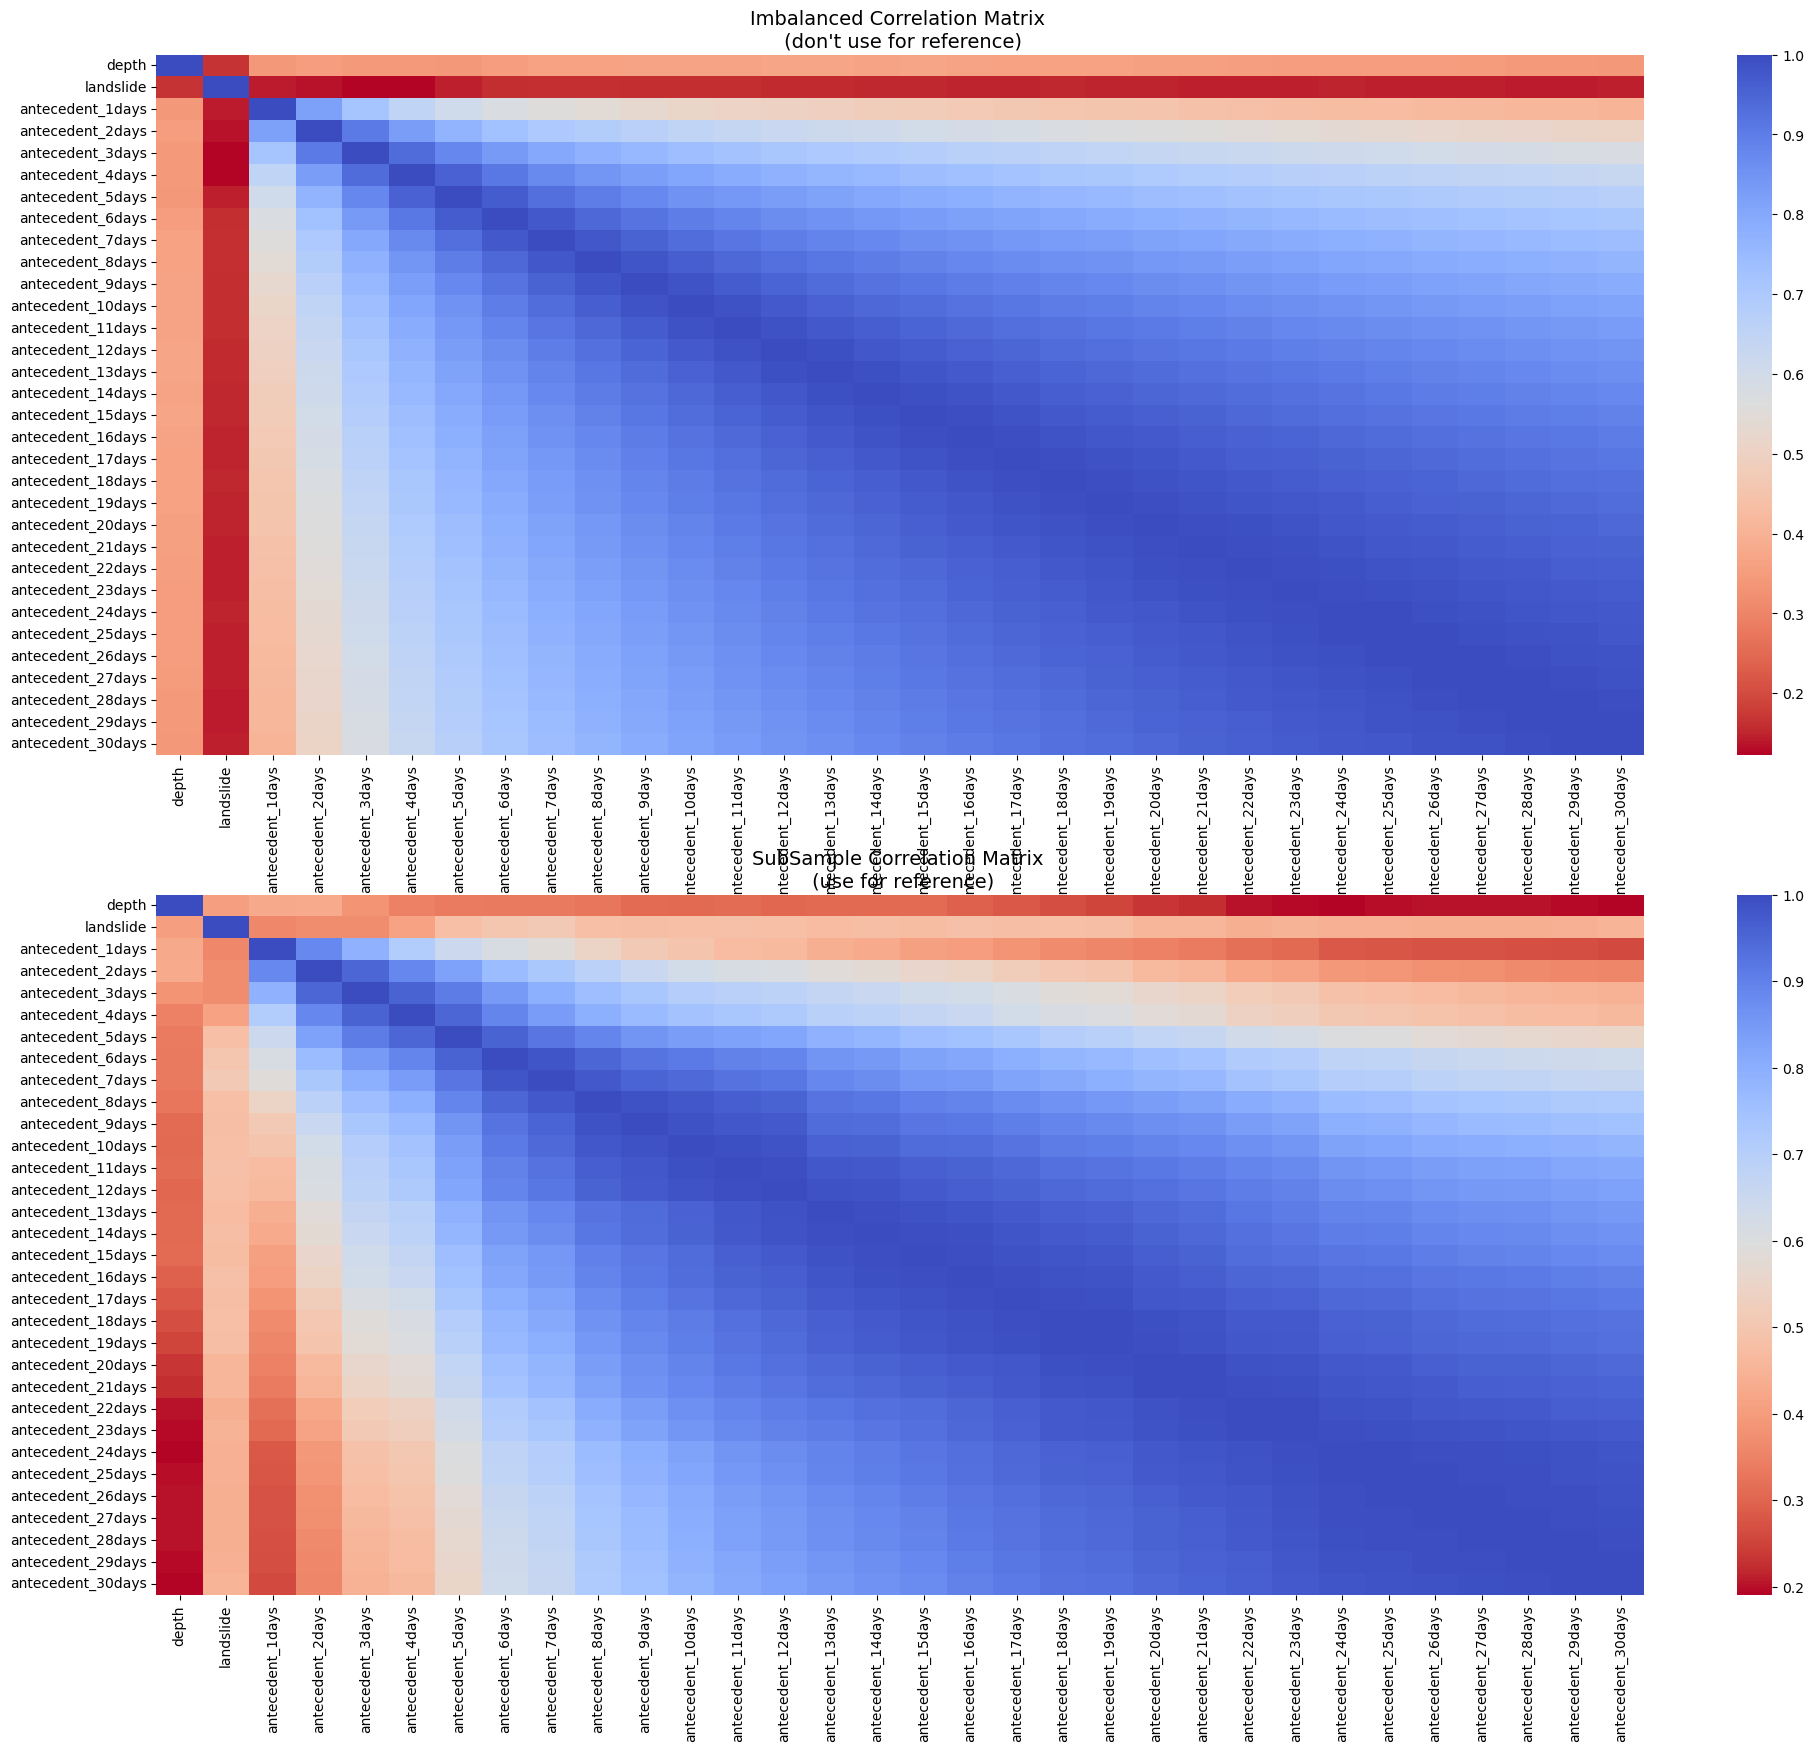

In [67]:

f, (ax1, ax2) = plt.subplots(2, 1, figsize=(24,20))

# Entire DataFrame
corr = df.corr()
sns.heatmap(corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax1)
ax1.set_title("Imbalanced Correlation Matrix \n (don't use for reference)", fontsize=14)


sub_sample_corr = new_df.corr()
sns.heatmap(sub_sample_corr, cmap='coolwarm_r', annot_kws={'size':20}, ax=ax2)
ax2.set_title('SubSample Correlation Matrix \n (use for reference)', fontsize=14)
plt.show()

In [69]:
st.subheader('Imbalanced Correlation Matrix ')
st.pyplot(f)


DeltaGenerator()

# lets ruduce the dimentionality for our data while securing the features

In [70]:
# New_df is from the random undersample data (fewer instances)
X = new_df.drop('landslide', axis=1)
y = new_df['landslide']

# since our data is multi dimentional reducing the dimensionality of high-dimensional data while preserving the structure
# and relationships between data points lets use T-SNE 
# T-SNE Implementation
t0 = time.time()
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("T-SNE took {:.2} s".format(t1 - t0))
#Principal Component Analysis (PCA) is a dimensionality reduction technique used in data analysis and machine learning to 
#reduce the number of features (variables) in a dataset while preserving as much of the variance in the data as possible.
#PCA achieves this by transforming the original features into a new set of uncorrelated variables called principal components. 
# PCA Implementation
t0 = time.time()
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X.values)
t1 = time.time()
print("PCA took {:.2} s".format(t1 - t0))
#Truncated Singular Value Decomposition (TruncatedSVD) is a dimensionality reduction technique closely related to 
#Principal Component Analysis (PCA), but it operates on sparse data and is typically used for linear dimensionality 
#reduction when working with large and sparse datasets.
# TruncatedSVD
t0 = time.time()
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X.values)
t1 = time.time()
print("Truncated SVD took {:.2} s".format(t1 - t0))


T-SNE took 0.73 s
PCA took 0.0 s
Truncated SVD took 0.0 s


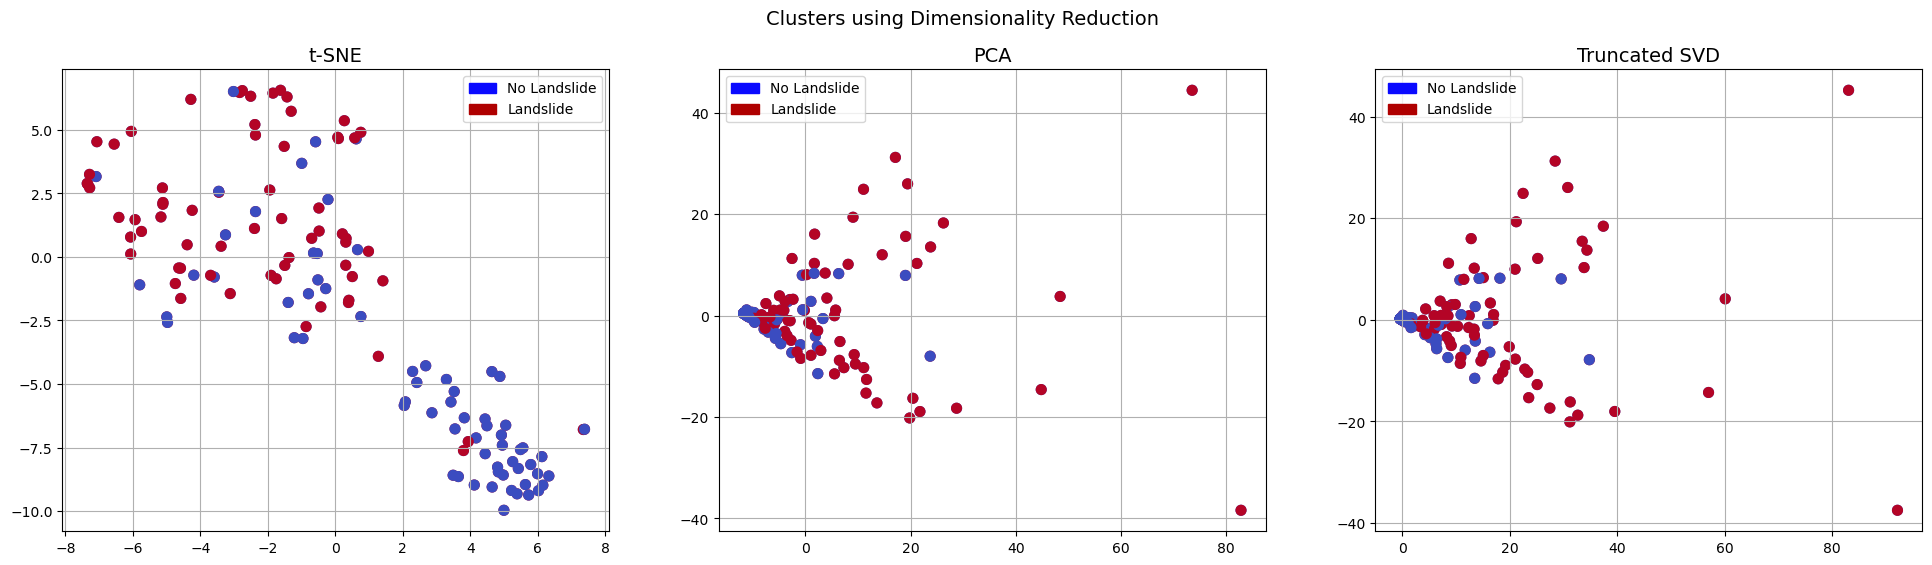

In [71]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24,6))
# labels = ['No Fraud', 'Fraud']
f.suptitle('Clusters using Dimensionality Reduction', fontsize=14)


blue_patch = mpatches.Patch(color='#0A0AFF', label='No Landslide')
red_patch = mpatches.Patch(color='#AF0000', label='Landslide')


# t-SNE scatter plot
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 0), cmap='coolwarm', label='No Landslide', linewidths=2)
ax1.scatter(X_reduced_tsne[:,0], X_reduced_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Landslide', linewidths=2)
ax1.set_title('t-SNE', fontsize=14)

ax1.grid(True)

ax1.legend(handles=[blue_patch, red_patch])


# PCA scatter plot
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 0), cmap='coolwarm', label='No Landslide', linewidths=2)
ax2.scatter(X_reduced_pca[:,0], X_reduced_pca[:,1], c=(y == 1), cmap='coolwarm', label='Landslide', linewidths=2)
ax2.set_title('PCA', fontsize=14)

ax2.grid(True)

ax2.legend(handles=[blue_patch, red_patch])

# TruncatedSVD scatter plot
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 0), cmap='coolwarm', label='No Landslide', linewidths=2)
ax3.scatter(X_reduced_svd[:,0], X_reduced_svd[:,1], c=(y == 1), cmap='coolwarm', label='Landslide', linewidths=2)
ax3.set_title('Truncated SVD', fontsize=14)

ax3.grid(True)

ax3.legend(handles=[blue_patch, red_patch])

plt.show()

In [72]:
st.subheader('Clusters using Dimensionality Reduction ')
st.pyplot(f)

DeltaGenerator()

# Undersampling before cross validating (prone to overfit)

In [73]:
X = new_df.drop('landslide', axis=1)
y = new_df['landslide']

# Our data is already scaled we should split our training and test sets


In [74]:
from sklearn.model_selection import train_test_split

# This is explicitly used for undersampling.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Turn the values into an array for feeding the classification algorithms.


In [75]:
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

# Let's implement simple classifiers


In [76]:

classifiers = {
    "LogisiticRegression": LogisticRegression(),
    "KNearest": KNeighborsClassifier(),
    "Support Vector Classifier": SVC(),
    "DecisionTreeClassifier": DecisionTreeClassifier(),
    "CatBoostClassifier": CatBoostClassifier()

}

# our scores are getting even high scores even when applying cross validation.


In [77]:
from sklearn.model_selection import cross_val_score


for key, classifier in classifiers.items():
    classifier.fit(X_train, y_train)
    training_score = cross_val_score(classifier, X_train, y_train, cv=5)
    print("Classifiers: ", classifier.__class__.__name__, "Has a training score of", round(training_score.mean(), 2) * 100, "% accuracy score")

Classifiers:  LogisticRegression Has a training score of 78.0 % accuracy score
Classifiers:  KNeighborsClassifier Has a training score of 72.0 % accuracy score
Classifiers:  SVC Has a training score of 79.0 % accuracy score
Classifiers:  DecisionTreeClassifier Has a training score of 77.0 % accuracy score
Learning rate set to 0.003967
0:	learn: 0.6892135	total: 4.38ms	remaining: 4.38s
1:	learn: 0.6863089	total: 7.36ms	remaining: 3.67s
2:	learn: 0.6833333	total: 10.3ms	remaining: 3.43s
3:	learn: 0.6806626	total: 13.8ms	remaining: 3.43s
4:	learn: 0.6781896	total: 16.8ms	remaining: 3.35s
5:	learn: 0.6752023	total: 20.6ms	remaining: 3.42s
6:	learn: 0.6719945	total: 23.9ms	remaining: 3.39s
7:	learn: 0.6689287	total: 27ms	remaining: 3.35s
8:	learn: 0.6655129	total: 30.4ms	remaining: 3.34s
9:	learn: 0.6630207	total: 33.8ms	remaining: 3.34s
10:	learn: 0.6606759	total: 37.2ms	remaining: 3.35s
11:	learn: 0.6582284	total: 40.4ms	remaining: 3.33s
12:	learn: 0.6556177	total: 43.5ms	remaining: 3.3s


# Let's use GridSearchCV to find the best parameters.


In [78]:
from sklearn.model_selection import GridSearchCV


# Logistic Regression 
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}



grid_log_reg = GridSearchCV(LogisticRegression(), log_reg_params)
grid_log_reg.fit(X_train, y_train)
# We automatically get the logistic regression with the best parameters.
log_reg = grid_log_reg.best_estimator_

knears_params = {"n_neighbors": list(range(2,5,1)), 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

grid_knears = GridSearchCV(KNeighborsClassifier(), knears_params)
grid_knears.fit(X_train, y_train)
# KNears best estimator
knears_neighbors = grid_knears.best_estimator_

# Support Vector Classifier
svc_params = {'C': [0.5, 0.7, 0.9, 1], 'kernel': ['rbf', 'poly', 'sigmoid', 'linear']}
grid_svc = GridSearchCV(SVC(), svc_params)
grid_svc.fit(X_train, y_train)

# SVC best estimator
svc = grid_svc.best_estimator_

# DecisionTree Classifier
tree_params = {"criterion": ["gini", "entropy"], "max_depth": list(range(2,4,1)), 
              "min_samples_leaf": list(range(5,7,1))}
grid_tree = GridSearchCV(DecisionTreeClassifier(), tree_params)
grid_tree.fit(X_train, y_train)

# tree best estimator
tree_clf = grid_tree.best_estimator_

cat_clf = CatBoostClassifier(iterations=500, learning_rate=0.1, depth=6, loss_function='Logloss', 
                           eval_metric='Accuracy', random_seed=42, logging_level='Silent')

# Train the model
cat_clf.fit(X_train, y_train)

# Overfitting Case
Overfitting occurs when a model learns the details and noise in the training data to the extent that it negatively impacts its performance on new, unseen data. In other words, an overfit model captures the noise in the training data, rather than the underlying pattern. This often leads to poor generalization, where the model performs well on the training data but fails to make accurate predictions on new, unseen data.

lets find the cross validation scores of all the 4 models

In [79]:

log_reg_score = cross_val_score(log_reg, X_train, y_train, cv=5)
print('Logistic Regression Cross Validation Score: ', round(log_reg_score.mean() * 100, 2).astype(str) + '%')


knears_score = cross_val_score(knears_neighbors, X_train, y_train, cv=5)
print('Knears Neighbors Cross Validation Score', round(knears_score.mean() * 100, 2).astype(str) + '%')

svc_score = cross_val_score(svc, X_train, y_train, cv=5)
print('Support Vector Classifier Cross Validation Score', round(svc_score.mean() * 100, 2).astype(str) + '%')

tree_score = cross_val_score(tree_clf, X_train, y_train, cv=5)
print('DecisionTree Classifier Cross Validation Score', round(tree_score.mean() * 100, 2).astype(str) + '%')

cat_score=cross_val_score(cat_clf,X_train,y_train,cv=5)
print('CatBoost Classifier Cross Validation Score', round(tree_score.mean() * 100, 2).astype(str) + '%')


Logistic Regression Cross Validation Score:  79.48%
Knears Neighbors Cross Validation Score 75.71%
Support Vector Classifier Cross Validation Score 79.48%
DecisionTree Classifier Cross Validation Score 75.71%
CatBoost Classifier Cross Validation Score 75.71%


# undersample during cross validating

Undersampling during cross-validation addresses class imbalance by ensuring equal representation of both classes in training folds. In situations where one class dominates, randomly selecting a subset of majority class samples for each fold balances the dataset. This promotes fairer model evaluation, preventing bias towards the majority class and improving overall accuracy.

In [84]:
undersample_X = df.drop('landslide', axis=1)
undersample_y = df['landslide']

for train_index, test_index in sss.split(undersample_X, undersample_y):
    print("Train:", train_index, "Test:", test_index)
    undersample_Xtrain, undersample_Xtest = undersample_X.iloc[train_index], undersample_X.iloc[test_index]
    undersample_ytrain, undersample_ytest = undersample_y.iloc[train_index], undersample_y.iloc[test_index]
    
undersample_Xtrain = undersample_Xtrain.values
undersample_Xtest = undersample_Xtest.values
undersample_ytrain = undersample_ytrain.values
undersample_ytest = undersample_ytest.values 

undersample_accuracy = []
undersample_precision = []
undersample_recall = []
undersample_f1 = []
undersample_auc = []

# Implementing NearMiss Technique 
# Distribution of NearMiss (Just to see how it distributes the labels we won't use these variables)
X_nearmiss, y_nearmiss = NearMiss().fit_resample(undersample_X.values, undersample_y.values)
print('NearMiss Label Distribution: {}'.format(Counter(y_nearmiss)))
# Cross Validating the right way

for train, test in sss.split(undersample_Xtrain, undersample_ytrain):
    undersample_pipeline = imbalanced_make_pipeline(NearMiss(), log_reg) # SMOTE happens during Cross Validation not before..
    undersample_model = undersample_pipeline.fit(undersample_Xtrain[train], undersample_ytrain[train])
    undersample_prediction = undersample_model.predict(undersample_Xtrain[test])
    
    undersample_accuracy.append(undersample_pipeline.score(original_Xtrain[test], original_ytrain[test]))
    undersample_precision.append(precision_score(original_ytrain[test], undersample_prediction))
    undersample_recall.append(recall_score(original_ytrain[test], undersample_prediction))
    undersample_f1.append(f1_score(original_ytrain[test], undersample_prediction))
    undersample_auc.append(roc_auc_score(original_ytrain[test], undersample_prediction))

Train: [4118 2083 2623 ... 3131 3714 5078] Test: [1838  473 2524 ...  824 1990 1155]
Train: [2809 2478 5348 ... 4833 3047 5725] Test: [2557 5461 2410 ...  492  981 2093]
Train: [ 337 2662 3916 ... 2507 2017 3938] Test: [3476 1904 2464 ... 1300 5222  435]
Train: [1373 1498 2486 ... 3177 1956 5803] Test: [2905 2802 2235 ... 3346 2086 5743]
Train: [5187  148 4753 ... 1187 1087 2219] Test: [ 281 4833 4954 ...  436  103 1702]
NearMiss Label Distribution: Counter({0.0: 67, 1.0: 67})


# Let's Plot  Learning Curve


In [87]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator1, estimator2, estimator3, estimator4, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20,14), sharey=True)
    if ylim is not None:
        plt.ylim(*ylim)
    # First Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator1, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax1.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax1.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax1.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax1.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax1.set_title("Logistic Regression Learning Curve", fontsize=14)
    ax1.set_xlabel('Training size (m)')
    ax1.set_ylabel('Score')
    ax1.grid(True)
    ax1.legend(loc="best")
    
    # Second Estimator 
    train_sizes, train_scores, test_scores = learning_curve(
        estimator2, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax2.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax2.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax2.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax2.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax2.set_title("Knears Neighbors Learning Curve", fontsize=14)
    ax2.set_xlabel('Training size (m)')
    ax2.set_ylabel('Score')
    ax2.grid(True)
    ax2.legend(loc="best")
    
    # Third Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator3, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax3.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax3.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax3.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax3.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax3.set_title("Support Vector Classifier \n Learning Curve", fontsize=14)
    ax3.set_xlabel('Training size (m)')
    ax3.set_ylabel('Score')
    ax3.grid(True)
    ax3.legend(loc="best")
    

# fourth Estimator
    train_sizes, train_scores, test_scores = learning_curve(
        estimator4, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    ax4.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="#ff9124")
    ax4.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="#2492ff")
    ax4.plot(train_sizes, train_scores_mean, 'o-', color="#ff9124",
             label="Training score")
    ax4.plot(train_sizes, test_scores_mean, 'o-', color="#2492ff",
             label="Cross-validation score")
    ax4.set_title("DecisionTree Classifier \n Learning Curve", fontsize=14)
    ax4.set_xlabel('Training size (m)')
    ax4.set_ylabel('Score')
    ax4.grid(True)
    ax4.legend(loc="best")
    return plt

# Let's Plot LogisticRegression Learning Curve


In [88]:
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
plot_learning_curve(log_reg, knears_neighbors, svc, tree_clf, X_train, y_train, (0.87, 1.01), cv=cv, n_jobs=4)

<module 'matplotlib.pyplot' from 'C:\\anaconda\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [89]:
def plot_learning_curve(estimator1, estimator2, estimator3, estimator4, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 14), sharey=True)
    if ylim is not None:
        plt.ylim(*ylim)
    st.pyplot(f)
cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=42)
# Streamlit app
st.title("Learning Curve Visualization")
st.write("This Streamlit app displays learning curves for multiple classifiers.")
plot_learning_curve(log_reg, knears_neighbors, svc, tree_clf, X_train, y_train, (0.87, 1.01), cv=cv, n_jobs=4)

In [90]:
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_predict
# Create a DataFrame with all the scores and the classifiers names.

log_reg_pred = cross_val_predict(log_reg, X_train, y_train, cv=5,
                             method="decision_function")

knears_pred = cross_val_predict(knears_neighbors, X_train, y_train, cv=5)

svc_pred = cross_val_predict(svc, X_train, y_train, cv=5,
                             method="decision_function")

tree_pred = cross_val_predict(tree_clf, X_train, y_train, cv=5)

Cat_pred=cross_val_predict(cat_clf,X_train,y_train,cv=5)

In [91]:
from sklearn.metrics import roc_auc_score

print('Logistic Regression: ', roc_auc_score(y_train, log_reg_pred))
print('KNears Neighbors: ', roc_auc_score(y_train, knears_pred))
print('Support Vector Classifier: ', roc_auc_score(y_train, svc_pred))
print('Decision Tree Classifier: ', roc_auc_score(y_train, tree_pred))
print('Catboost Classifier: ', roc_auc_score(y_train, Cat_pred))

Logistic Regression:  0.8748251748251749
KNears Neighbors:  0.7573426573426574
Support Vector Classifier:  0.8517482517482518
Decision Tree Classifier:  0.7583916083916084
Catboost Classifier:  0.7674825174825175


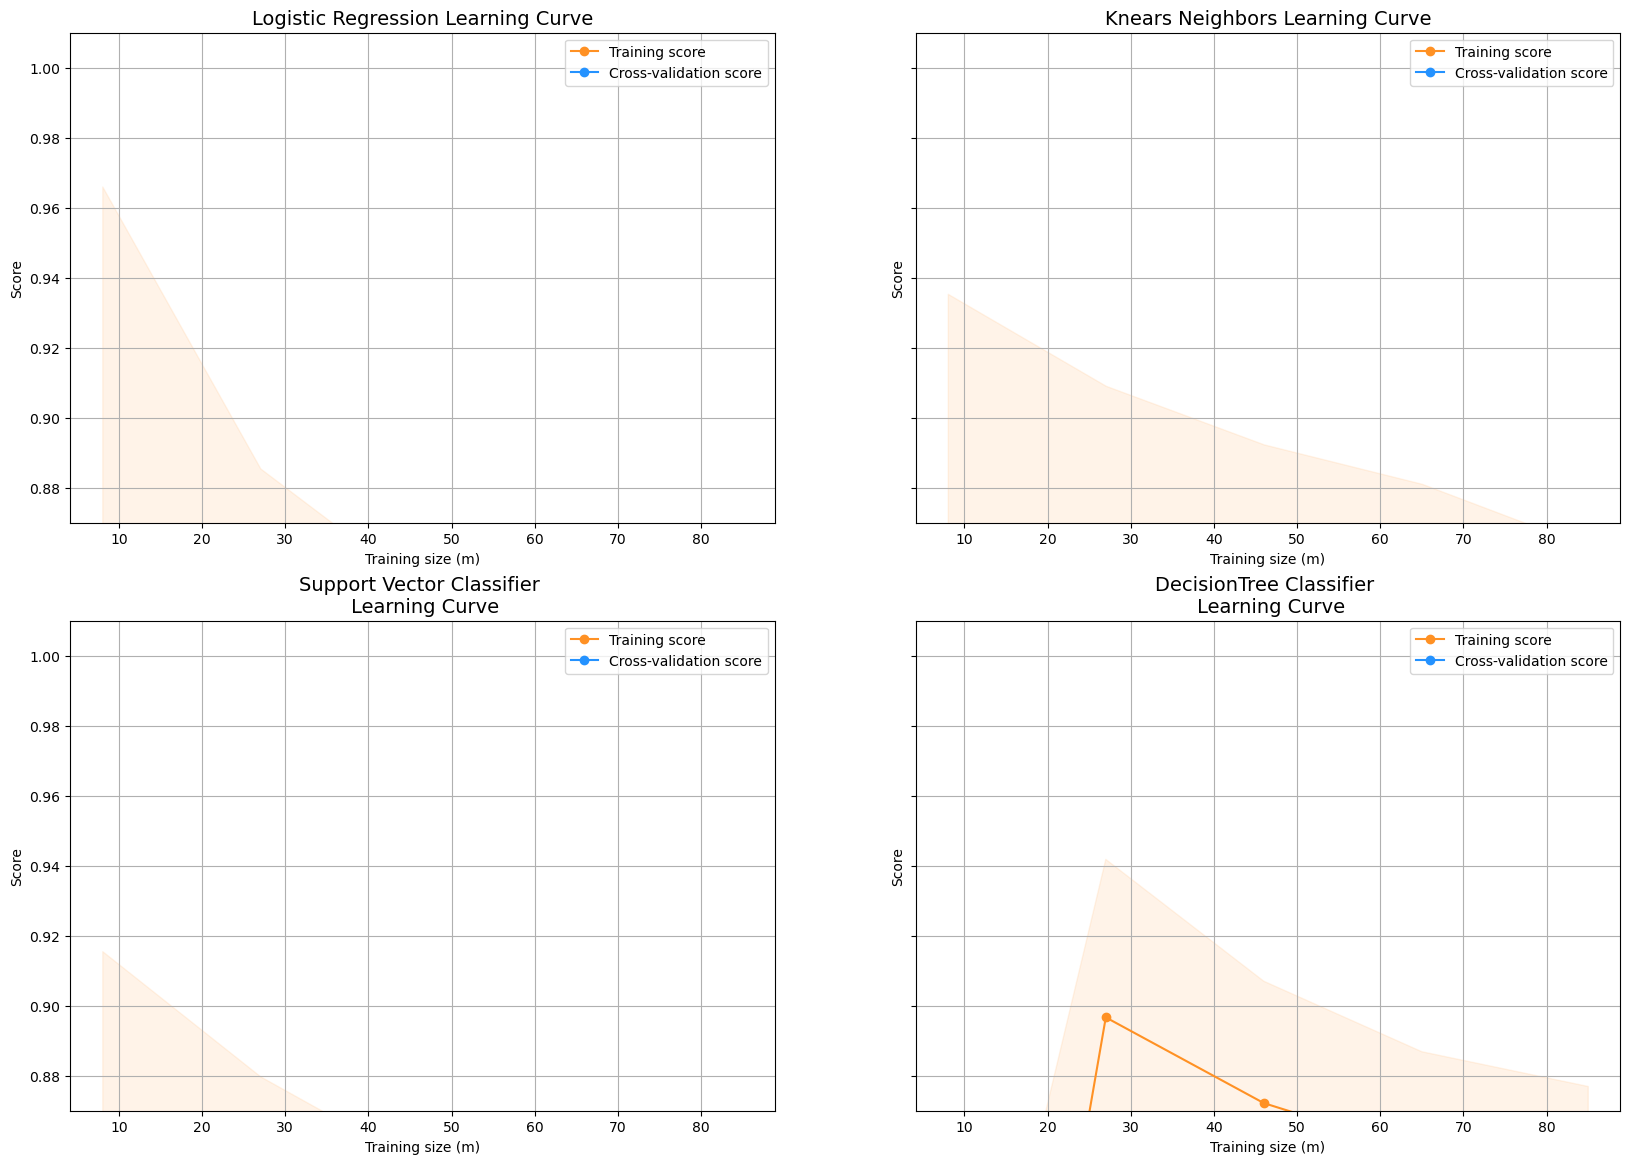

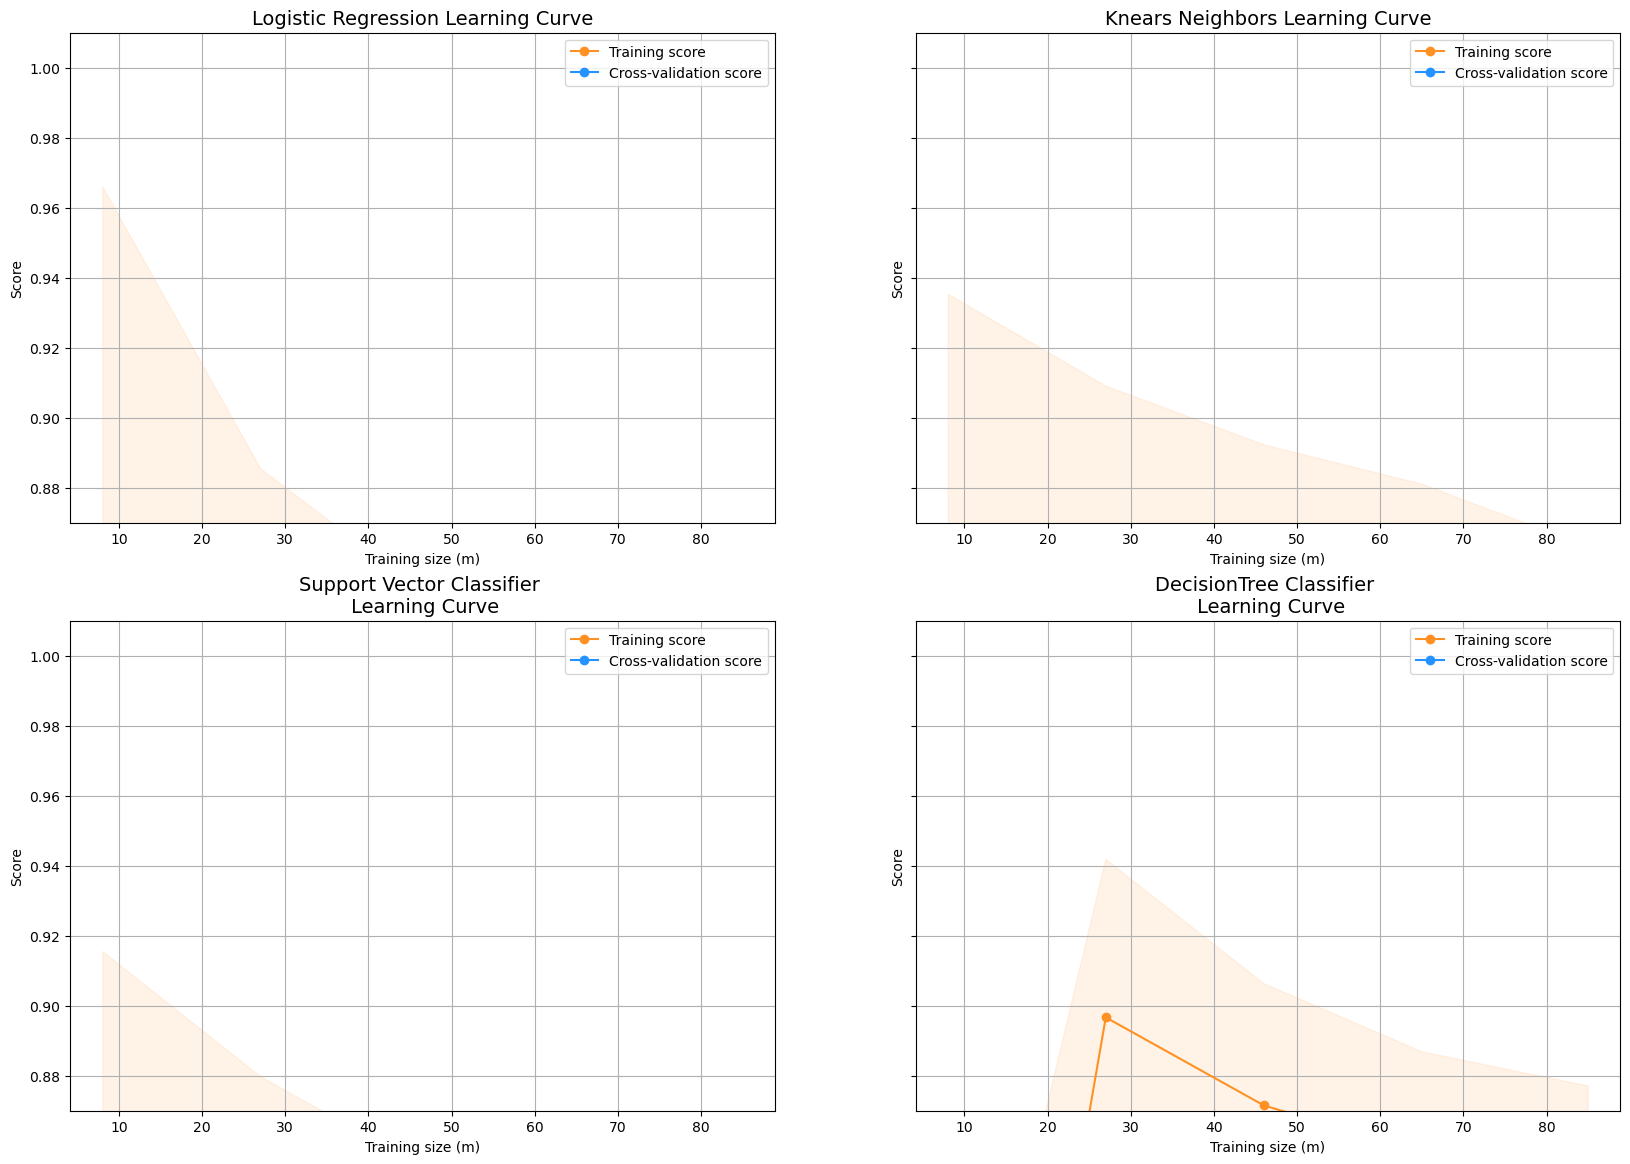

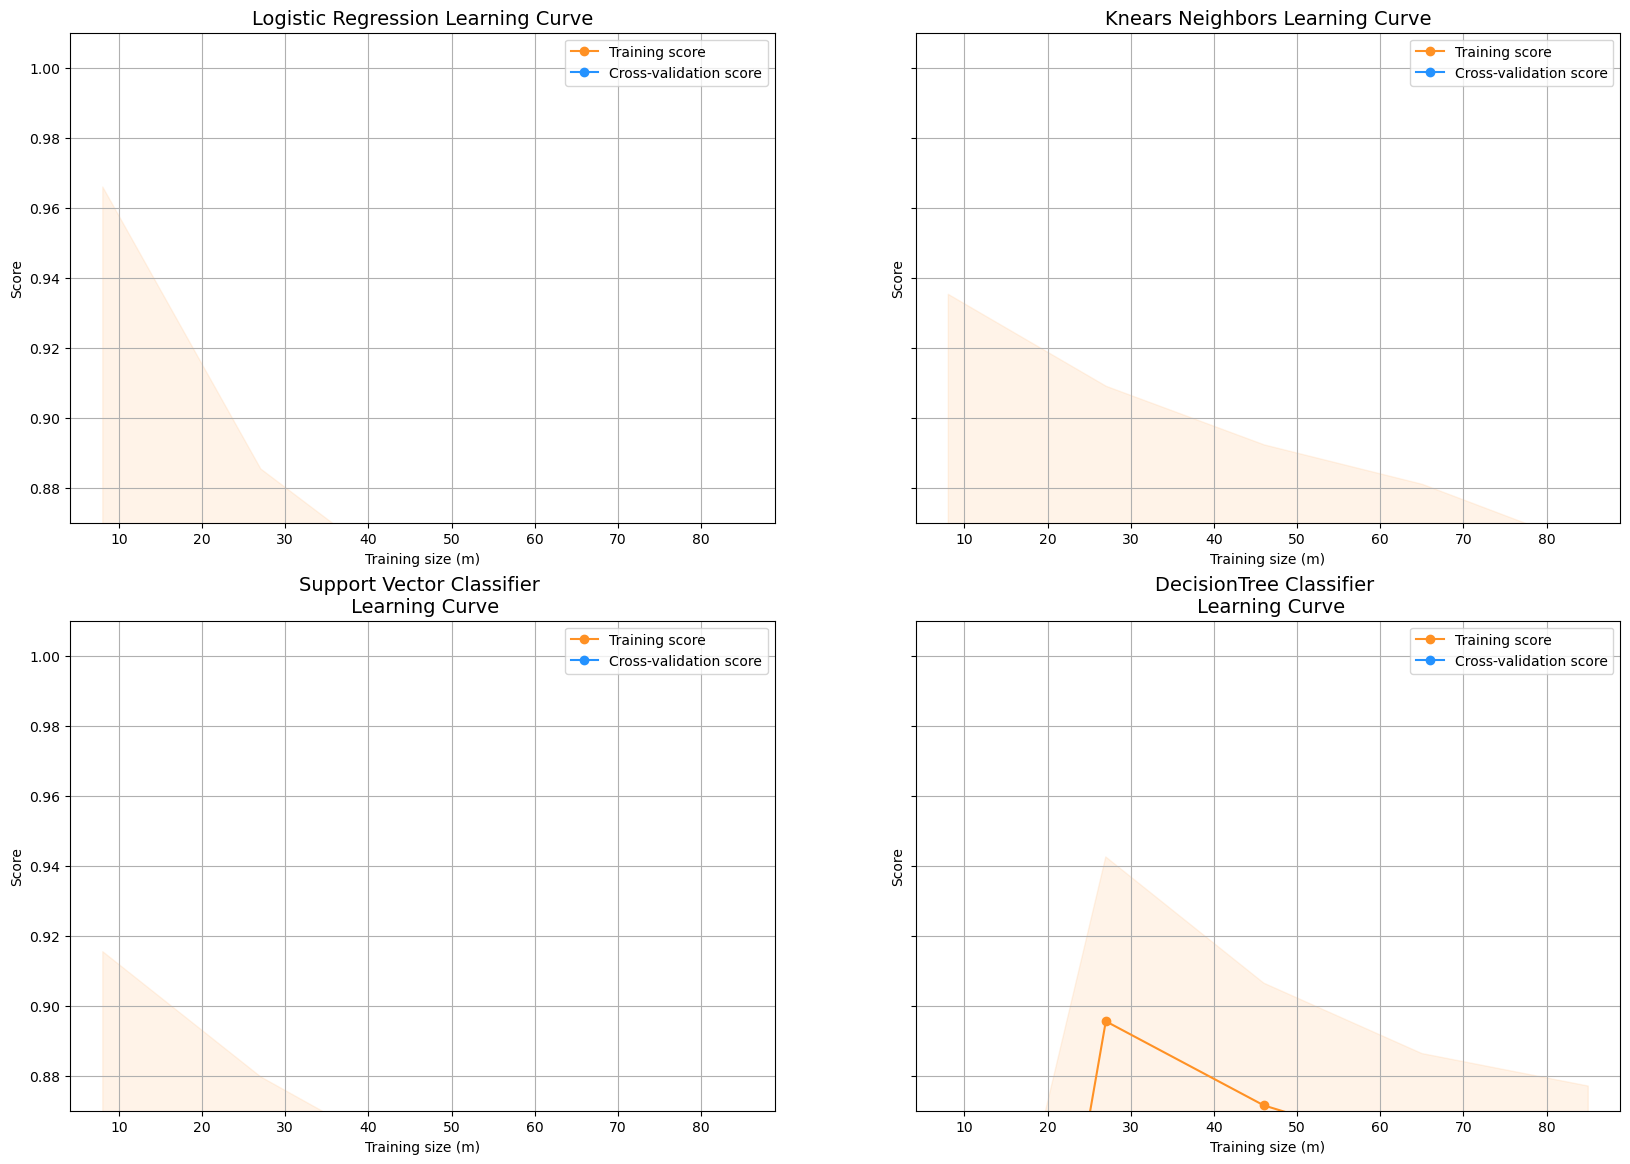

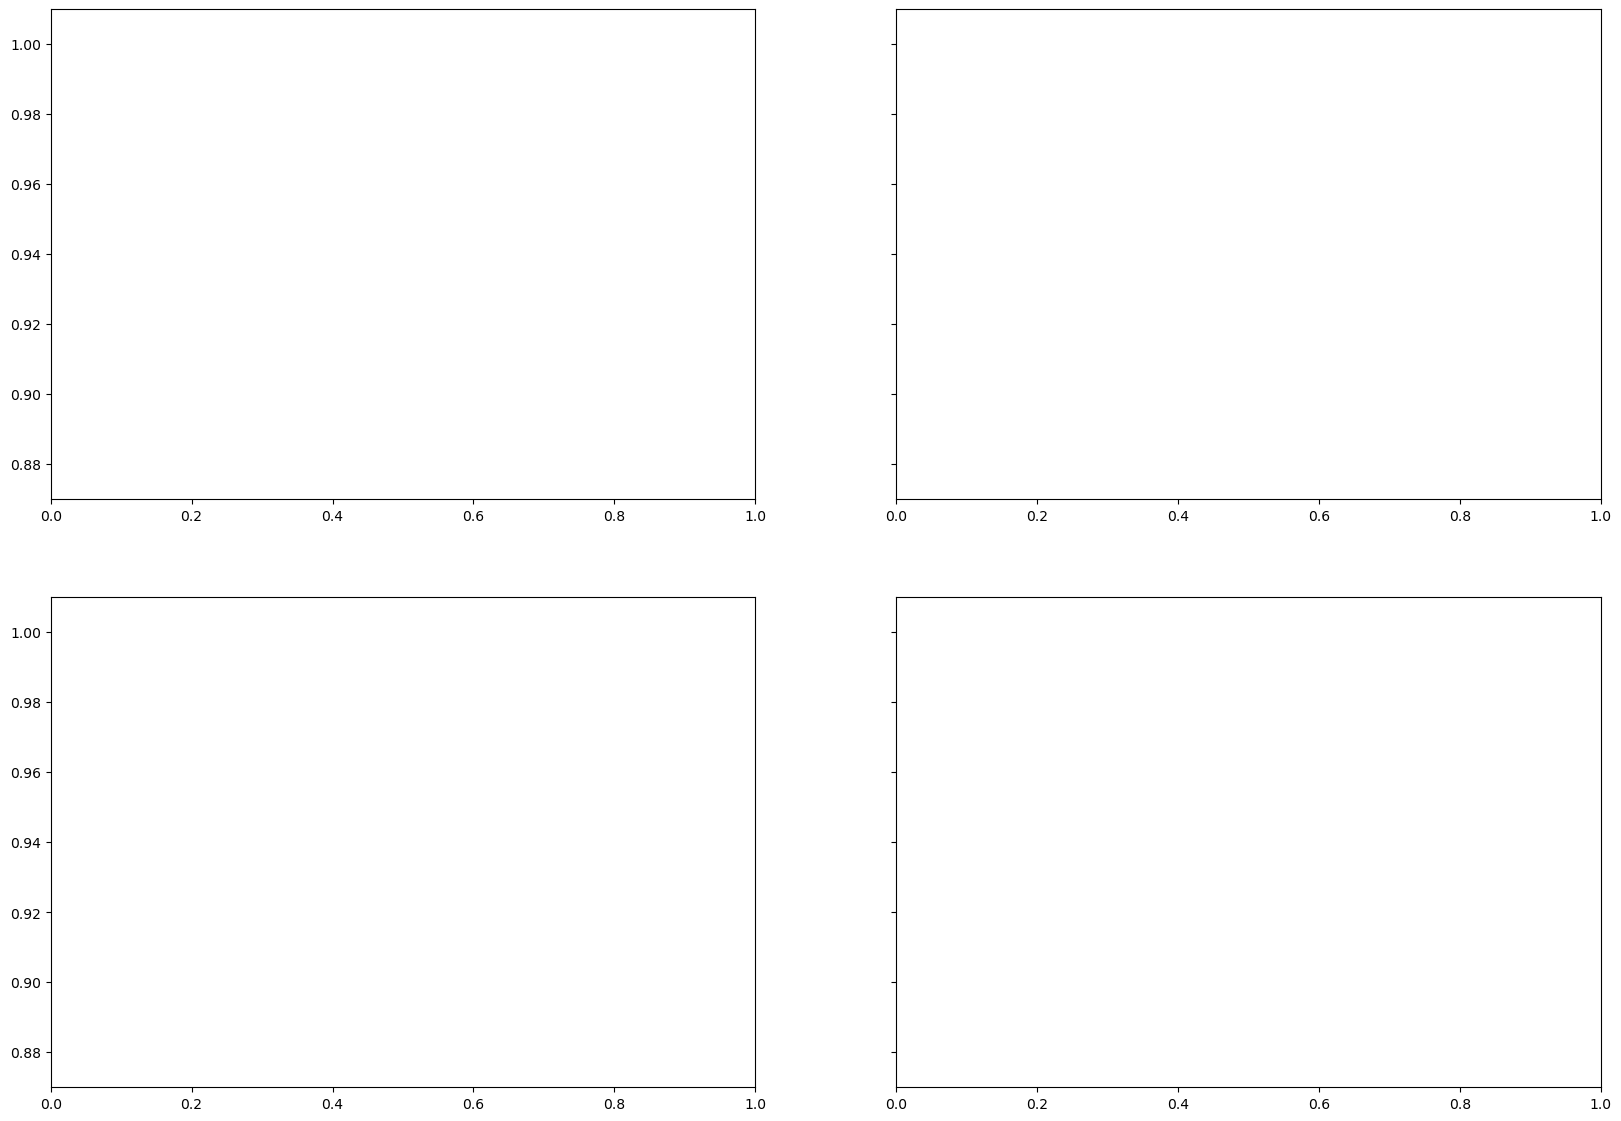

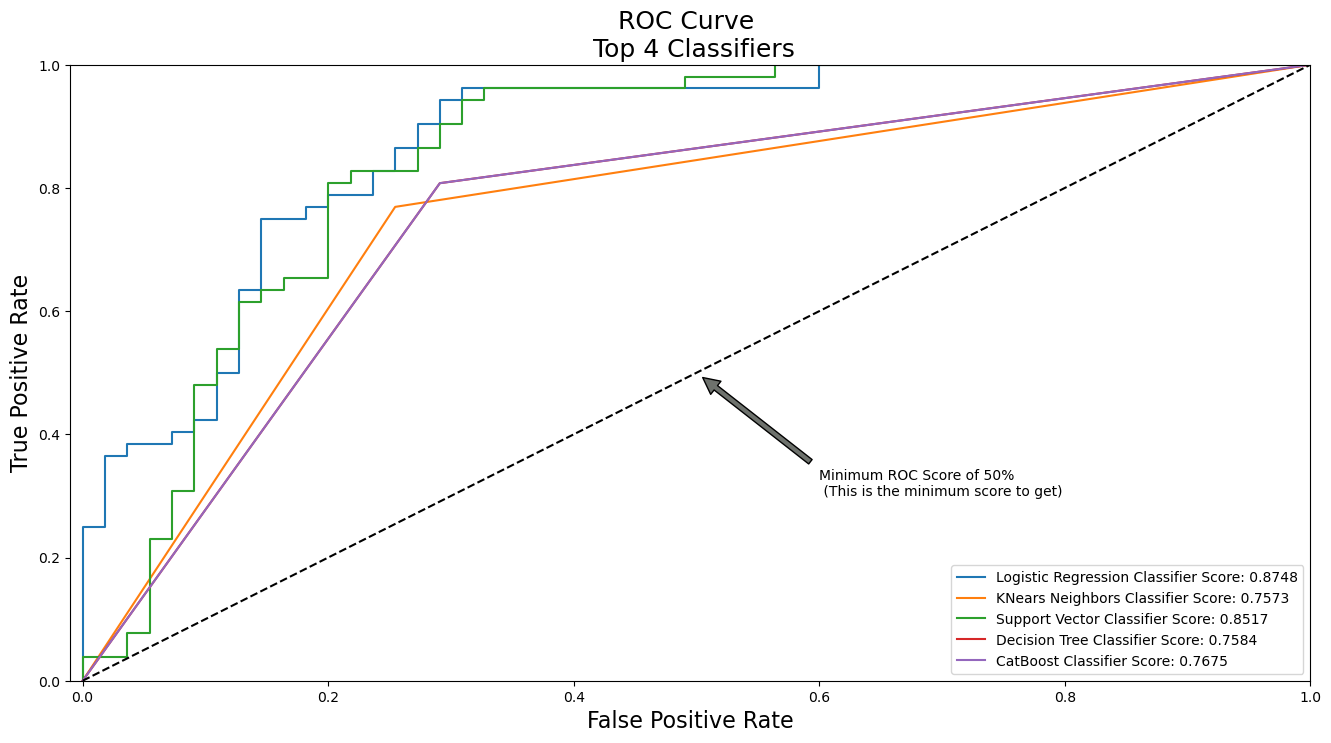

In [92]:
log_fpr, log_tpr, log_thresold = roc_curve(y_train, log_reg_pred)
knear_fpr, knear_tpr, knear_threshold = roc_curve(y_train, knears_pred)
svc_fpr, svc_tpr, svc_threshold = roc_curve(y_train, svc_pred)
tree_fpr, tree_tpr, tree_threshold = roc_curve(y_train, tree_pred)


def graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr):
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve \n Top 4 Classifiers', fontsize=18)
    plt.plot(log_fpr, log_tpr, label='Logistic Regression Classifier Score: {:.4f}'.format(roc_auc_score(y_train, log_reg_pred)))
    plt.plot(knear_fpr, knear_tpr, label='KNears Neighbors Classifier Score: {:.4f}'.format(roc_auc_score(y_train, knears_pred)))
    plt.plot(svc_fpr, svc_tpr, label='Support Vector Classifier Score: {:.4f}'.format(roc_auc_score(y_train, svc_pred)))
    plt.plot(tree_fpr, tree_tpr, label='Decision Tree Classifier Score: {:.4f}'.format(roc_auc_score(y_train, tree_pred)))
    plt.plot(tree_fpr, tree_tpr, label='CatBoost Classifier Score: {:.4f}'.format(roc_auc_score(y_train, Cat_pred)))

    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.annotate('Minimum ROC Score of 50% \n (This is the minimum score to get)', xy=(0.5, 0.5), xytext=(0.6, 0.3),
                arrowprops=dict(facecolor='#6E726D', shrink=0.05),
                )
    plt.legend()
    
graph_roc_curve_multiple(log_fpr, log_tpr, knear_fpr, knear_tpr, svc_fpr, svc_tpr, tree_fpr, tree_tpr)
plt.show()

In [93]:
st.title("ROC Curve Visualization")
st.write("This Streamlit app displays the ROC curve for multiple classifiers.")
st.pyplot(plt)


DeltaGenerator()

<Figure size 640x480 with 0 Axes>

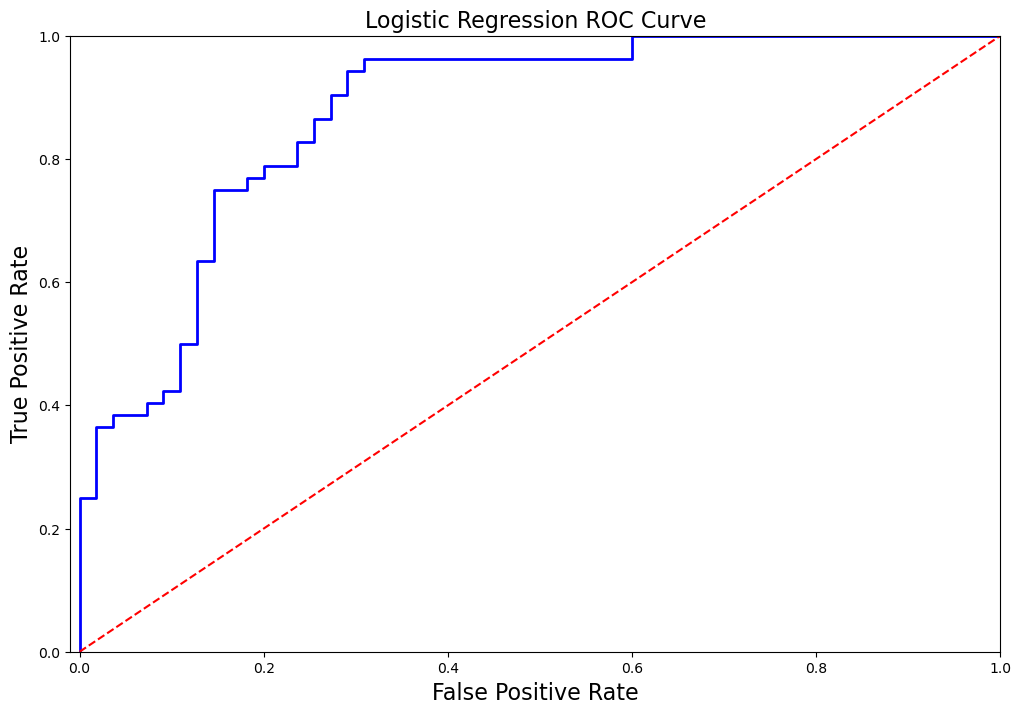

In [94]:
def logistic_roc_curve(log_fpr, log_tpr):
    plt.figure(figsize=(12,8))
    plt.title('Logistic Regression ROC Curve', fontsize=16)
    plt.plot(log_fpr, log_tpr, 'b-', linewidth=2)
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.axis([-0.01,1,0,1])
    
    
logistic_roc_curve(log_fpr, log_tpr)
plt.show()

In [95]:
from sklearn.metrics import precision_recall_curve

precision, recall, threshold = precision_recall_curve(y_train, log_reg_pred)

In [96]:
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score
y_pred = log_reg.predict(X_train)

# Overfitting Case
print('---' * 45)
print('Overfitting: \n')
print('Recall Score: {:.2f}'.format(recall_score(y_train, y_pred)))
print('Precision Score: {:.2f}'.format(precision_score(y_train, y_pred)))
print('F1 Score: {:.2f}'.format(f1_score(y_train, y_pred)))
print('Accuracy Score: {:.2f}'.format(accuracy_score(y_train, y_pred)))
print('---' * 45)

# How it should look like
print('---' * 45)
print('How it should be:\n')
print("Accuracy Score: {:.2f}".format(np.mean(undersample_accuracy)))
print("Precision Score: {:.2f}".format(np.mean(undersample_precision)))
print("Recall Score: {:.2f}".format(np.mean(undersample_recall)))
print("F1 Score: {:.2f}".format(np.mean(undersample_f1)))
print('---' * 45)

---------------------------------------------------------------------------------------------------------------------------------------
Overfitting: 

Recall Score: 0.71
Precision Score: 0.80
F1 Score: 0.76
Accuracy Score: 0.78
---------------------------------------------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------------------------------------------
How it should be:

Accuracy Score: 0.82
Precision Score: 0.04
Recall Score: 0.76
F1 Score: 0.08
---------------------------------------------------------------------------------------------------------------------------------------


In [97]:
undersample_y_score = log_reg.decision_function(original_Xtest)

In [98]:
from sklearn.metrics import average_precision_score

undersample_average_precision = average_precision_score(original_ytest, undersample_y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      undersample_average_precision))

Average precision-recall score: 0.10


In [99]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(original_ytest, undersample_y_score)

plt.step(recall, precision, color='#004a93', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#48a6ff')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('UnderSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          undersample_average_precision), fontsize=16)

Text(0.5, 1.0, 'UnderSampling Precision-Recall curve: \n Average Precision-Recall Score =0.10')

In [100]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV


print('Length of X (train): {} | Length of y (train): {}'.format(len(original_Xtrain), len(original_ytrain)))
print('Length of X (test): {} | Length of y (test): {}'.format(len(original_Xtest), len(original_ytest)))

# List to append the score and then find the average
accuracy_lst = []
precision_lst = []
recall_lst = []
f1_lst = []
auc_lst = []

# Classifier with optimal parameters
# log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm = LogisticRegression()




rand_log_reg = RandomizedSearchCV(LogisticRegression(), log_reg_params, n_iter=4)


# Implementing SMOTE Technique 
# Cross Validating the right way
# Parameters
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
for train, test in sss.split(original_Xtrain, original_ytrain):
    pipeline = imbalanced_make_pipeline(SMOTE(random_state=42), rand_log_reg) # SMOTE happens during Cross Validation not before..
    model = pipeline.fit(original_Xtrain[train], original_ytrain[train])
    best_est = rand_log_reg.best_estimator_
    prediction = best_est.predict(original_Xtrain[test])
    
    accuracy_lst.append(pipeline.score(original_Xtrain[test], original_ytrain[test]))
    precision_lst.append(precision_score(original_ytrain[test], prediction))
    recall_lst.append(recall_score(original_ytrain[test], prediction))
    f1_lst.append(f1_score(original_ytrain[test], prediction))
    auc_lst.append(roc_auc_score(original_ytrain[test], prediction))
    
print('---' * 45)
print('')
print("accuracy: {}".format(np.mean(accuracy_lst)))
print("precision: {}".format(np.mean(precision_lst)))
print("recall: {}".format(np.mean(recall_lst)))
print("f1: {}".format(np.mean(f1_lst)))
print('---' * 45)

Length of X (train): 4672 | Length of y (train): 4672
Length of X (test): 1169 | Length of y (test): 1169
---------------------------------------------------------------------------------------------------------------------------------------

accuracy: 0.8506951871657755
precision: 0.05789329591320715
recall: 0.7636363636363637
f1: 0.10761677028534991
---------------------------------------------------------------------------------------------------------------------------------------


In [101]:
labels = ['No Landslide', 'Landslide']
smote_prediction = best_est.predict(original_Xtest)
print(classification_report(original_ytest, smote_prediction, target_names=labels))

              precision    recall  f1-score   support

No Landslide       1.00      0.85      0.92      1156
   Landslide       0.05      0.77      0.10        13

    accuracy                           0.85      1169
   macro avg       0.53      0.81      0.51      1169
weighted avg       0.99      0.85      0.91      1169



In [102]:
y_score = best_est.decision_function(original_Xtest)

In [103]:
average_precision = average_precision_score(original_ytest, y_score)

print('Average precision-recall score: {0:0.2f}'.format(
      average_precision))

Average precision-recall score: 0.13


In [104]:
fig = plt.figure(figsize=(12,6))

precision, recall, _ = precision_recall_curve(original_ytest, y_score)

plt.step(recall, precision, color='r', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='#F59B00')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('OverSampling Precision-Recall curve: \n Average Precision-Recall Score ={0:0.2f}'.format(
          average_precision), fontsize=16)

Text(0.5, 1.0, 'OverSampling Precision-Recall curve: \n Average Precision-Recall Score =0.13')

In [105]:
import pandas as pd
import numpy as np
# SMOTE Technique (OverSampling) After splitting and Cross Validating
sm = SMOTE(sampling_strategy='minority',random_state=42)
# Xsm_train, ysm_train = sm.fit_sample(X_train, y_train)
Xsm_train, ysm_train = sm.fit_resample(X_train, y_train)


# This will be the data were we are going to 
#Xsm_train, ysm_train = sm.fit_sample(original_Xtrain, original_ytrain)
#X_train_smote, y_train_smote = sm.fit_resample(original_Xtrain.iloc[train], original_ytrain.iloc[train])
X_train_smote, y_train_smote = sm.fit_resample(Xsm_train, ysm_train)


In [106]:
# We Improve the score by 2% points approximately 
# Implement GridSearchCV and the other models.

# Logistic Regression
t0 = time.time()
log_reg_sm = grid_log_reg.best_estimator_
log_reg_sm.fit(Xsm_train, ysm_train)
t1 = time.time()
print("Fitting oversample data took :{} sec".format(t1 - t0))

Fitting oversample data took :0.005494356155395508 sec


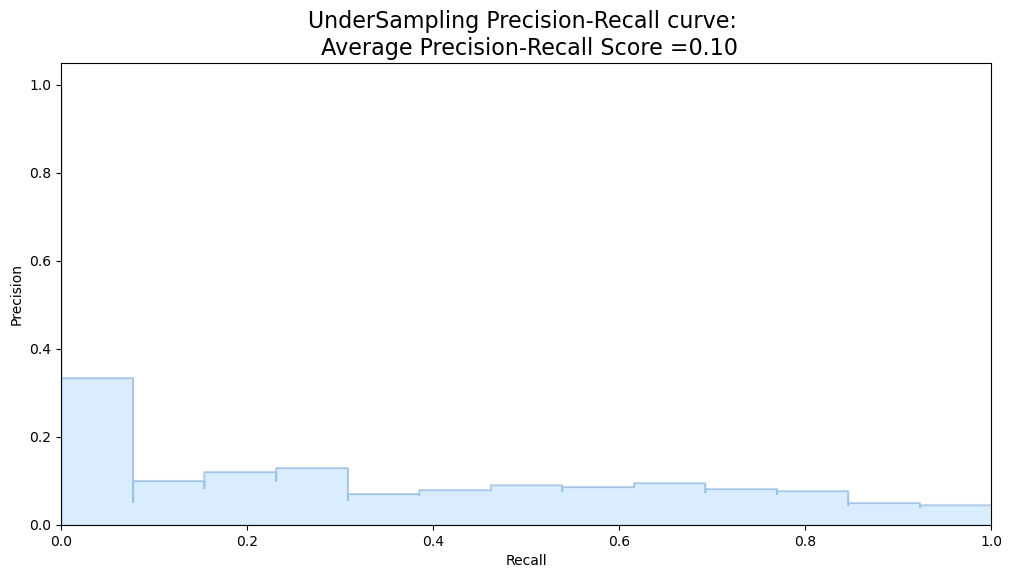

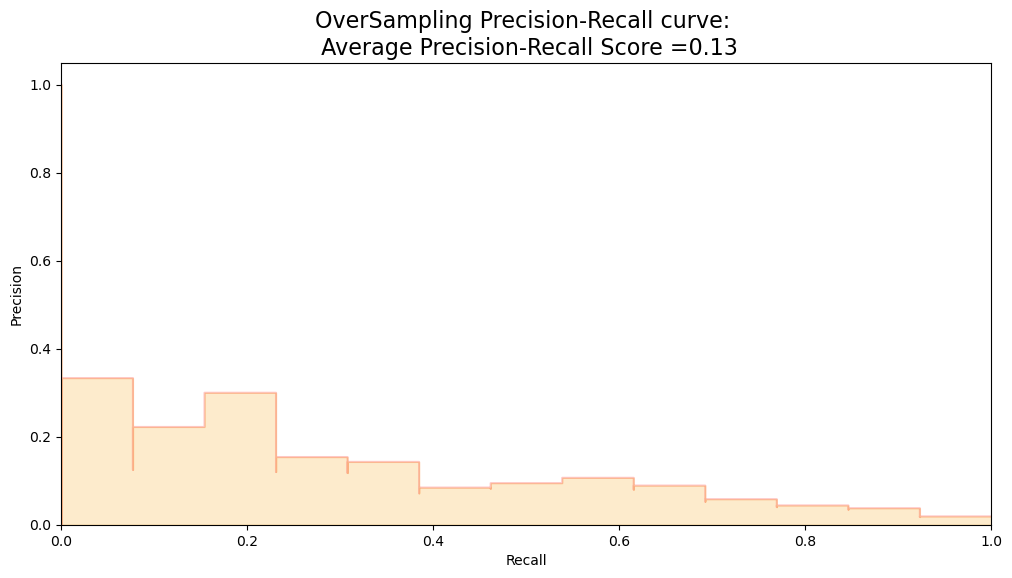

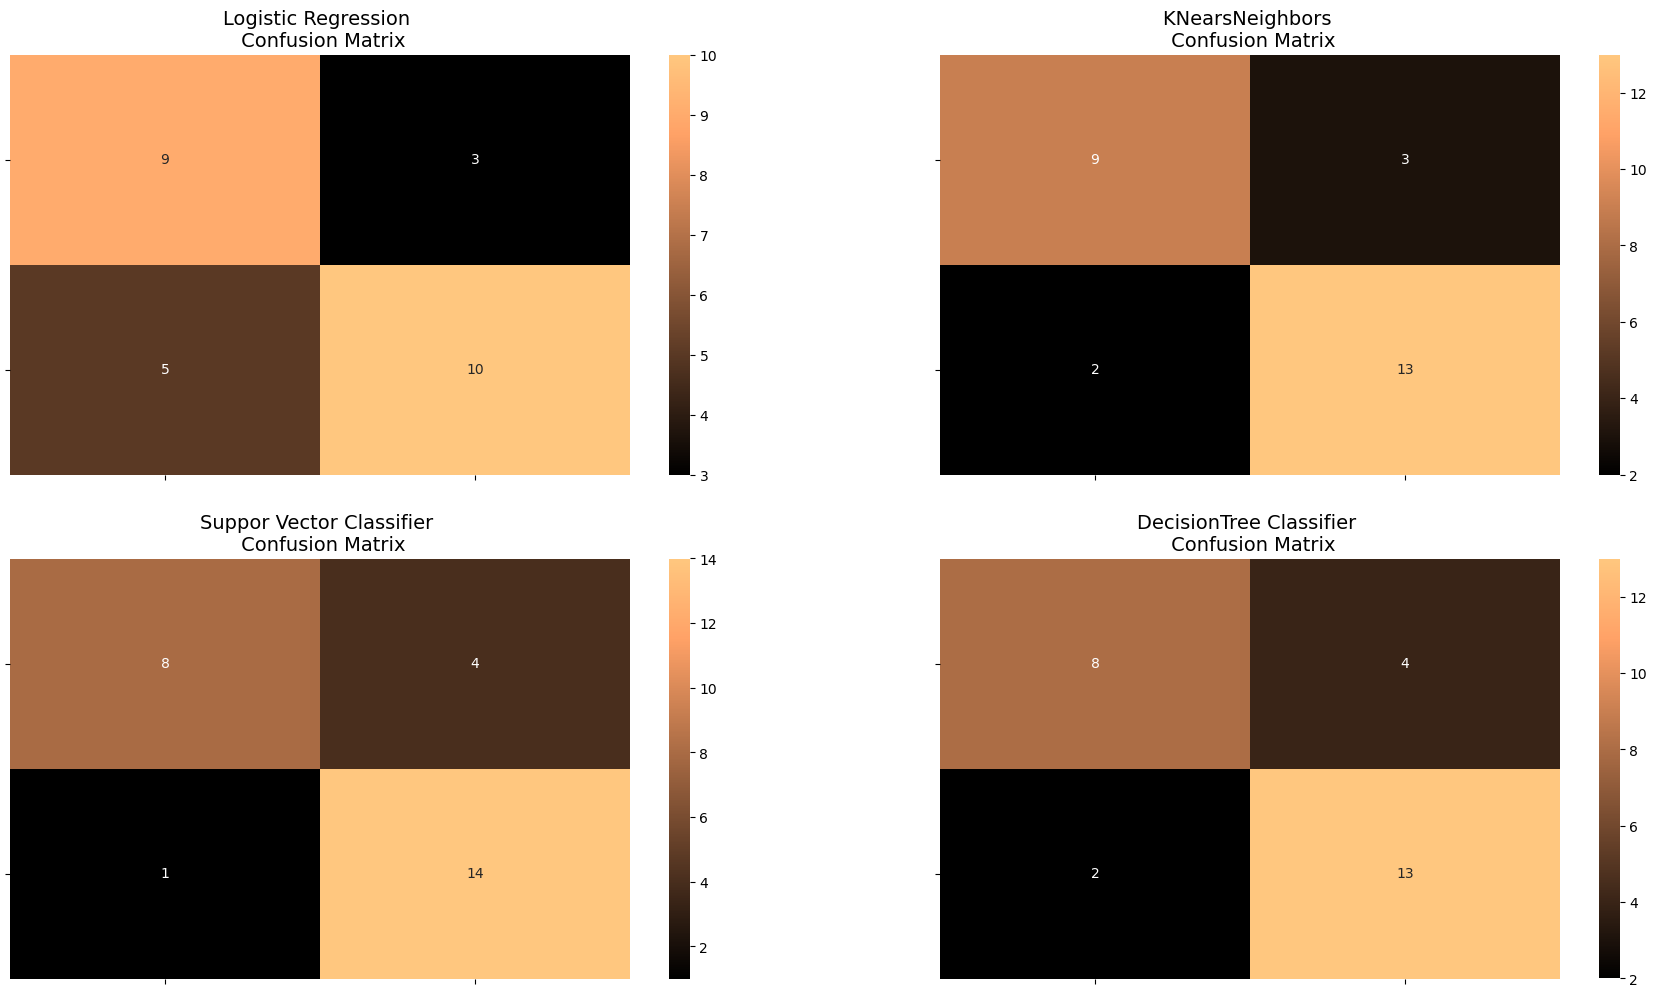

In [107]:
from sklearn.metrics import confusion_matrix

# Logistic Regression fitted using SMOTE technique
y_pred_log_reg = log_reg_sm.predict(X_test)

# Other models fitted with UnderSampling
y_pred_knear = knears_neighbors.predict(X_test)
y_pred_svc = svc.predict(X_test)
y_pred_tree = tree_clf.predict(X_test)
y_pred_cat=cat_clf.predict(X_test)

log_reg_cf = confusion_matrix(y_test, y_pred_log_reg)
kneighbors_cf = confusion_matrix(y_test, y_pred_knear)
svc_cf = confusion_matrix(y_test, y_pred_svc)
tree_cf = confusion_matrix(y_test, y_pred_tree)

fig, ax = plt.subplots(2, 2,figsize=(22,12))


sns.heatmap(log_reg_cf, ax=ax[0][0], annot=True, cmap=plt.cm.copper)
ax[0, 0].set_title("Logistic Regression \n Confusion Matrix", fontsize=14)
ax[0, 0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0, 0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(kneighbors_cf, ax=ax[0][1], annot=True, cmap=plt.cm.copper)
ax[0][1].set_title("KNearsNeighbors \n Confusion Matrix", fontsize=14)
ax[0][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0][1].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(svc_cf, ax=ax[1][0], annot=True, cmap=plt.cm.copper)
ax[1][0].set_title("Suppor Vector Classifier \n Confusion Matrix", fontsize=14)
ax[1][0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][0].set_yticklabels(['', ''], fontsize=14, rotation=360)

sns.heatmap(tree_cf, ax=ax[1][1], annot=True, cmap=plt.cm.copper)
ax[1][1].set_title("DecisionTree Classifier \n Confusion Matrix", fontsize=14)
ax[1][1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1][1].set_yticklabels(['', ''], fontsize=14, rotation=360)


plt.show()

In [108]:
st.title("Confusion Matrix Visualization")
st.write("This Streamlit app displays confusion matrices for multiple classifiers.")
st.pyplot(fig)


DeltaGenerator()

In [109]:
from sklearn.metrics import classification_report


print('Logistic Regression:')
print(classification_report(y_test, y_pred_log_reg))

print('KNears Neighbors:')
print(classification_report(y_test, y_pred_knear))

print('Support Vector Classifier:')
print(classification_report(y_test, y_pred_svc))

print('Decision Tree Classifier:')
print(classification_report(y_test, y_pred_tree))
print('CatBoost Classifier:')
print(classification_report(y_test, y_pred_cat))


Logistic Regression:
              precision    recall  f1-score   support

         0.0       0.64      0.75      0.69        12
         1.0       0.77      0.67      0.71        15

    accuracy                           0.70        27
   macro avg       0.71      0.71      0.70        27
weighted avg       0.71      0.70      0.70        27

KNears Neighbors:
              precision    recall  f1-score   support

         0.0       0.82      0.75      0.78        12
         1.0       0.81      0.87      0.84        15

    accuracy                           0.81        27
   macro avg       0.82      0.81      0.81        27
weighted avg       0.82      0.81      0.81        27

Support Vector Classifier:
              precision    recall  f1-score   support

         0.0       0.89      0.67      0.76        12
         1.0       0.78      0.93      0.85        15

    accuracy                           0.81        27
   macro avg       0.83      0.80      0.81        27
weighted

In [110]:
st.title("Classification Report Visualization")
st.write("This Streamlit app displays classification reports for multiple classifiers.")

# Display classification reports
st.write("Logistic Regression:")
st.text(classification_report(y_test, y_pred_log_reg))

st.write("KNears Neighbors:")
st.text(classification_report(y_test, y_pred_knear))

st.write("Support Vector Classifier:")
st.text(classification_report(y_test, y_pred_svc))

st.write("Decision Tree Classifier:")
st.text(classification_report(y_test, y_pred_tree))

# Assuming you have defined y_pred_cat
st.write("CatBoost Classifier:")
st.text(classification_report(y_test, y_pred_cat))

# Additional Streamlit content if needed
st.write("Additional Streamlit content goes here.")

In [128]:
# Final Score in the test set of logistic regression
from sklearn.metrics import accuracy_score

# Logistic Regression with Under-Sampling
y_pred = log_reg.predict(X_test)
undersample_score = accuracy_score(y_test, y_pred)



# Logistic Regression with SMOTE Technique (Better accuracy with SMOTE t)
y_pred_sm = best_est.predict(original_Xtest)
oversample_score = accuracy_score(original_ytest, y_pred_sm)


d = {'Technique': ['Random UnderSampling', 'Oversampling (SMOTE)'], 'Score': [undersample_score, oversample_score]}
final_df = pd.DataFrame(data=d)

# Move column
score = final_df['Score']
final_df.drop('Score', axis=1, inplace=True)
final_df.insert(1, 'Score', score)

# Note how high is accuracy score it can be misleading! 
final_df

,Technique,Score
0,Random UnderSampling,0.081527
1,Oversampling (SMOTE),0.848589


In [129]:
#Importing
from scipy import stats
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import math
import joblib
from sklearn.model_selection import train_test_split


In [130]:
#val - number of days
def antecedent_rainfall(dr,val):
    for i in range(1,val+1):
        s = "antecedent_"+ str(i) + "days"
        x = i + 1
        dr[s] = np.around(abs(dr.depth.rolling(x).sum() - dr.depth),decimals=7)
        
    return dr
#15days antecedent rainfall
#antecedent_rainfall(dr,180)

In [131]:
#Preprocessing rainfall data (dr)
def preprocessing_of_rainfall_data(data, frequency_of_data):
    data = data.replace(-9999.9, np.nan)
    data.columns = ['time','intensity']
    
    data = data.fillna(0)
    data['depth'] = data['intensity'] * frequency_of_data
    data['time'] = pd.to_datetime(data['time'])
    data = data.set_index('time', drop=True)
    #del data.index.name
    
    data = data.drop(['intensity'],axis=1)
    
    return data

In [132]:
#Preprocessing landslide data (dl)
def preprocessing_of_landslide_data(data):
    data.columns = ['time','landslide']
    data['time'] = pd.to_datetime(data['time'])
    data = data.set_index('time', drop=True)
    #del data.index.name
    
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    
    landslide_years = data.index.year.unique()
    
    return data, landslide_years



In [133]:
#Merging both data  (df)
def merging_both_data(rainfall_data, landslide_data): 
    data = rainfall_data.join(landslide_data)
    
    data = data.fillna(0)
    data = data.drop(columns=['year','month','day'])
    
    
    return data


In [134]:
dr = preprocessing_of_rainfall_data(pd.read_csv('E:/New folder/landslide/78.9811,30.2587,79.5660,30.5506/LogisticModel/2003-2019/DailyTRMM.csv'), 24)
dl, landslide_years = preprocessing_of_landslide_data(pd.read_csv('E:/New folder/landslide/78.9811,30.2587,79.5660,30.5506/LogisticModel/Landslide - Sheet2.csv'))

In [135]:
dr = antecedent_rainfall(dr,30)

In [136]:
df = merging_both_data(dr,dl)

In [137]:
df = df.dropna(axis=0)

In [138]:

pd.value_counts(df['landslide']).plot.bar()
plt.title('Landslide class histogram')
plt.xlabel('Class')
plt.ylabel('Frequency')
df['landslide'].value_counts()

0.0    5804
1.0      67
Name: landslide, dtype: int64

In [139]:
X =  df.drop('landslide',axis=1)
Y = df['landslide']
X_train, X_test, y_train, y_test =train_test_split(X,Y,
                                                   test_size=0.33,
                                                   random_state=0,
                                                   stratify=df['landslide'])

# XG Boost Model

In [140]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score
#from sklearn.cross_validation import train_test_split
seed = 123
df

,depth,antecedent_1days,antecedent_2days,antecedent_3days,antecedent_4days,antecedent_5days,antecedent_6days,antecedent_7days,antecedent_8days,antecedent_9days,...,antecedent_22days,antecedent_23days,antecedent_24days,antecedent_25days,antecedent_26days,antecedent_27days,antecedent_28days,antecedent_29days,antecedent_30days,landslide
time,,,,,,,,,,,,,,,,,,,,,
2003-03-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2003-03-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2003-03-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2003-03-04,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
2003-03-05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-03-23,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.360000,9.360000,9.360000,101.159995,...,323.279992,323.279992,323.279992,487.799992,487.799992,487.799992,487.799992,487.799992,532.799993,0.0
2019-03-24,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.360000,9.360000,9.360000,...,323.279992,323.279992,323.279992,323.279992,487.799992,487.799992,487.799992,487.799992,487.799992,0.0
2019-03-25,569.160005,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.360000,9.360000,...,280.079993,323.279992,323.279992,323.279992,323.279992,487.799992,487.799992,487.799992,487.799992,0.0


In [141]:
y = df['landslide']
X = df.drop(columns=['landslide'])
last_row = X.tail(1)

#send last row to rpi
filename = 'last_row'
joblib.dump(last_row,filename)


['last_row']

In [142]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.33, stratify=y, random_state=seed)

print(y_train.sum())
print(y_test.sum())

45.0
22.0


In [143]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

In [144]:
params = {
    'objective':'binary:logistic',
    'max_depth':1,
    'silent':1,
    'eta':1
    
}

num_rounds = 15

In [145]:
bst = xgb.train(params,dtrain,num_rounds)
y_test_preds = (bst.predict(dtest)>0.5).astype('int')


In [146]:
y_test_preds

array([0, 0, 0, ..., 0, 0, 0])

In [147]:
pd.crosstab(y_test,y_test_preds,margins=True)


col_0,0,All
landslide,,
0.0,1916,1916
1.0,22,22
All,1938,1938


In [148]:

print('Accuracy: {0:.2f}'.format(accuracy_score(y_test,y_test_preds)))
print('Precision: {0:.2f}'.format(precision_score(y_test,y_test_preds)))
print('Recall: {0:.2f}'.format(recall_score(y_test,y_test_preds)))
weights = np.zeros(len(y_train))
weights[y_train == 0] = 1
weights[y_train == 1] = 10

dtrain = xgb.DMatrix(X_train,label=y_train,weight=weights)
dtest = xgb.DMatrix(X_test)



Accuracy: 0.99
Precision: 0.00
Recall: 0.00


In [149]:
bst = xgb.train(params,dtrain,num_rounds)
y_test_preds = (bst.predict(dtest)>0.5).astype('int')


In [150]:

pd.crosstab(y_test,y_test_preds,margins=True)

print('Accuracy: {0:.2f}'.format(accuracy_score(y_test,y_test_preds)))
print('Precision: {0:.2f}'.format(precision_score(y_test,y_test_preds)))
print('Recall: {0:.2f}'.format(recall_score(y_test,y_test_preds)))

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test)

train_labels = dtrain.get_label()

ratio = float(np.sum(train_labels == 0)/ np.sum(train_labels == 1))
params['scale_pos_weight'] = ratio

params

bst = xgb.train(params,dtrain,num_rounds)
y_test_preds = (bst.predict(dtest) > 0.5).astype('int')

pd.crosstab(y_test,y_test_preds,margins=True)

print('Accuracy: {0:.2f}'.format(accuracy_score(y_test,y_test_preds)))
print('Precision: {0:.2f}'.format(precision_score(y_test,y_test_preds)))
print('Recall: {0:.2f}'.format(recall_score(y_test,y_test_preds)))


#Model Building
filename = 'finalmodel.model'
joblib.dump(bst,filename)





Accuracy: 0.97
Precision: 0.06
Recall: 0.09
Accuracy: 0.84
Precision: 0.05
Recall: 0.64


['finalmodel.model']

# CatBoost Model is found to produce the best accuracy and precision overall hence this will be the higest attained accuracy 

In [151]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit


In [152]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit


In [153]:
from catboost import CatBoostRegressor


In [154]:
# Import necessary libraries
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score


# Assuming you have your features in X and labels in y
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the CatBoostClassifier
model = CatBoostClassifier(iterations=500, learning_rate=0.1, depth=6, loss_function='Logloss', 
                           eval_metric='Accuracy', random_seed=42, logging_level='Silent')

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
predictions = model.predict(X_test)

# Calculate metrics
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average='weighted')
recall = recall_score(y_test, predictions, average='weighted')

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)


Accuracy: 0.9846808510638297
Precision: 0.969596378451788
Recall: 0.9846808510638297


In [155]:
st.title("CatBoost Classifier Results")
st.write("This Streamlit app displays results for a CatBoost Classifier.")
st.write("Accuracy:", accuracy)
st.write("Precision:", precision)
st.write("Recall:", recall)

In [157]:

#import Reddy_Purushotham_606_final as fp

In [156]:
st.set_option('deprecation.showPyplotGlobalUse', False)